# ResNet Model Training

This notebook contains model training process for ResNet model on three different deepfake detection datasets. The model training splitted into two parts, which are baseline model (base model without dropout) and the dropout model itself.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152, resnet
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import pickle
import os

## Define Dataset Directory

In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC"

In [3]:
cdf_train_dir = os.path.join(CDF_DATASET_DIR, "Train")
cdf_val_dir = os.path.join(CDF_DATASET_DIR, "Val")

df_train_dir = os.path.join(DF_DATASET_DIR, "Train")
df_val_dir = os.path.join(DF_DATASET_DIR, "Val")

dfdc_train_dir = os.path.join(DFDC_DATASET_DIR, "Train")
dfdc_val_dir = os.path.join(DFDC_DATASET_DIR, "Val")

## Image Data Generator for Each Dataset

In [4]:
def create_image_generator(dataset_dir):
    datagen = ImageDataGenerator(preprocessing_function=resnet.preprocess_input)
    image_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(128, 128),
        batch_size=32,
        color_mode="rgb",
        class_mode="binary",
        shuffle=True,
        seed=42
    )

    return image_generator

In [5]:
print("Celeb-DF-v2 Dataset")
cdf_train_generator = create_image_generator(cdf_train_dir)
cdf_val_generator = create_image_generator(cdf_val_dir)

print("\nDeeperForensics-1.0 Dataset")
df_train_generator = create_image_generator(df_train_dir)
df_val_generator = create_image_generator(df_val_dir)

print("\nDeepfake Detection Challenge Dataset")
dfdc_train_generator = create_image_generator(dfdc_train_dir)
dfdc_val_generator = create_image_generator(dfdc_val_dir)

Celeb-DF-v2 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

DeeperForensics-1.0 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Deepfake Detection Challenge Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Get the Best Hyperparameters from Tuner

In [6]:
TUNER_RESULT_DIR = "/kaggle/input/hyperparameter-tuning/tuner_result"
BASE_HP_TUNER_PROJECT_NAME = "base_hp"
DROPOUT_TUNER_PROJECT_NAME = "dropout_rate"

In [7]:
def get_best_hp_from_tuner(tuner_dir, project_name):
    tuner = kt.Hyperband(directory=tuner_dir,
                         project_name=project_name,
                         overwrite=False)

    best_hp = tuner.get_best_hyperparameters()[0].values
    return best_hp

### Base Hyperparameters

In [8]:
best_base_hp = get_best_hp_from_tuner(TUNER_RESULT_DIR, BASE_HP_TUNER_PROJECT_NAME)
best_base_hp

Reloading Tuner from /kaggle/input/hyperparameter-tuning/tuner_result/base_hp/tuner0.json


{'conv_layers': 4,
 'conv_1_filters': 256,
 'conv_2_filters': 224,
 'conv_3_filters': 256,
 'conv_1_kernel_size': 3,
 'conv_2_kernel_size': 3,
 'conv_3_kernel_size': 3,
 'dense_layers': 4,
 'dense_1_layer_units': 64,
 'dense_2_layer_units': 224,
 'learning_rate': 1e-05,
 'conv_4_filters': 256,
 'conv_4_kernel_size': 7,
 'dense_3_layer_units': 224,
 'dense_4_layer_units': 224,
 'dense_5_layer_units': 224,
 'conv_5_filters': 192,
 'conv_5_kernel_size': 3,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

### Dropout Hyperparameter

In [9]:
best_dropout_hp = get_best_hp_from_tuner(TUNER_RESULT_DIR, DROPOUT_TUNER_PROJECT_NAME)
best_dropout_hp

Reloading Tuner from /kaggle/input/hyperparameter-tuning/tuner_result/dropout_rate/tuner0.json


{'dropout_rate': 0.65,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

### Combine All Hyperparameters into a Dict

In [10]:
best_hp = {}

best_hp["conv_layers"] = best_base_hp.get("conv_layers")
for i in range(best_base_hp.get("conv_layers")):
    conv_filter_hp_name = f"conv_{i+1}_filters"
    conv_kernel_size_hp_name = f"conv_{i+1}_kernel_size"
    best_hp[conv_filter_hp_name] = best_base_hp.get(conv_filter_hp_name)
    best_hp[conv_kernel_size_hp_name] = best_base_hp.get(conv_kernel_size_hp_name)

best_hp["dense_layers"] = best_base_hp.get("dense_layers")
for i in range(best_base_hp.get("dense_layers")):
    dense_unit_hp_name = f"dense_{i+1}_layer_units"
    best_hp[dense_unit_hp_name] = best_base_hp.get(dense_unit_hp_name)

best_hp["dropout_rate"] = best_dropout_hp.get("dropout_rate")
best_hp["learning_rate"] = best_base_hp.get("learning_rate")

print("Best hyperparameters loaded\n")
for key in best_hp:
    print(f"{key}: {best_hp[key]}")

Best hyperparameters loaded

conv_layers: 4
conv_1_filters: 256
conv_1_kernel_size: 3
conv_2_filters: 224
conv_2_kernel_size: 3
conv_3_filters: 256
conv_3_kernel_size: 3
conv_4_filters: 256
conv_4_kernel_size: 7
dense_layers: 4
dense_1_layer_units: 64
dense_2_layer_units: 224
dense_3_layer_units: 224
dense_4_layer_units: 224
dropout_rate: 0.65
learning_rate: 1e-05


## Function to Create a ResNet Model

In [11]:
def create_resnet_model(hp, dropout=False):
    base_model = ResNet152(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.Sequential()
    model.add(base_model)

    model.add(tf.keras.layers.Flatten())

    for i in range(hp.get("dense_layers")):
        dense_units = hp.get(f"dense_{i+1}_layer_units")
        model.add(tf.keras.layers.Dense(dense_units, activation="relu"))

    if dropout:
        model.add(tf.keras.layers.Dropout(hp.get("dropout_rate")))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get("learning_rate")),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )

    return model

## Function to Plot Train Results

In [12]:
def plot_train_result(history, title="Training Result"):
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Val")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Function to Save Model Training History

In [13]:
def save_model_and_history(model, history, model_name):
    model_filename = f"{model_name}_model.keras"
    history_filename = f"{model_name}_history.pkl"

    model.save(model_filename)
    print(f"Model saved at {model_filename}")    

    with open(history_filename, "wb") as f:
        pickle.dump(history.history, f)
        print(f"Training history saved at {history_filename}")

## Model Training

In [14]:
NUM_EPOCHS = 50

### Baseline ResNet

#### Celeb-DF-v2 Dataset

In [15]:
baseline_resnet_cdf_model = create_resnet_model(best_hp)
baseline_resnet_cdf_model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [16]:
baseline_resnet_cdf_history = baseline_resnet_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730745008.404562     255 service.cc:145] XLA service 0x7caf88002770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730745008.404609     255 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/438 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.4844 - loss: 0.7796   

I0000 00:00:1730745016.193521     255 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 147s 270ms/step - accuracy: 0.6409 - loss: 0.6392 - val_accuracy: 0.6190 - val_loss: 0.6455
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.8923 - loss: 0.3242 - val_accuracy: 0.6640 - val_loss: 0.6907
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9555 - loss: 0.1586 - val_accuracy: 0.6750 - val_loss: 0.7667
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9800 - loss: 0.0831 - val_accuracy: 0.6535 - val_loss: 0.9624
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9919 - loss: 0.0479 - val_accuracy: 0.6865 - val_loss: 0.9512
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9962 - loss: 0.0281 - val_accuracy: 0.6695 - val_loss: 1.1364
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9976 - loss: 0.0179 - val_accuracy: 0.6655 - val_loss: 1.2897
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9978 - loss: 0.0118 - val_accur

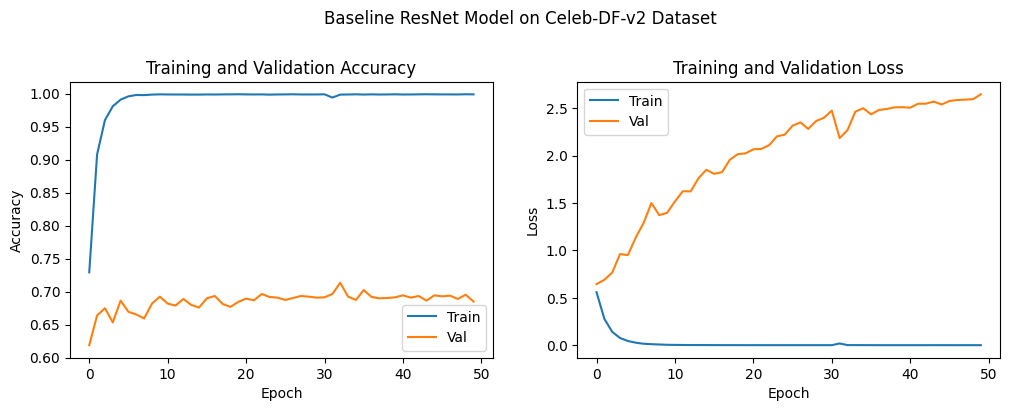

In [17]:
plot_train_result(
    baseline_resnet_cdf_history.history,
    title="Baseline ResNet Model on Celeb-DF-v2 Dataset"
)

In [18]:
save_model_and_history(
    baseline_resnet_cdf_model, baseline_resnet_cdf_history, "baseline_resnet_cdf"
)

Model saved at baseline_resnet_cdf_model.keras
Training history saved at baseline_resnet_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [19]:
baseline_resnet_df_model = create_resnet_model(best_hp)
baseline_resnet_df_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [20]:
baseline_resnet_df_history = baseline_resnet_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 164s 314ms/step - accuracy: 0.7962 - loss: 0.4396 - val_accuracy: 0.8210 - val_loss: 0.3537
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9932 - loss: 0.0437 - val_accuracy: 0.8605 - val_loss: 0.3246
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9983 - loss: 0.0133 - val_accuracy: 0.9030 - val_loss: 0.2368
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9993 - loss: 0.0063 - val_accuracy: 0.9140 - val_loss: 0.2084
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9996 - loss: 0.0035 - val_accuracy: 0.9055 - val_loss: 0.2397
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9135 - val_loss: 0.2131
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.9135 - val_loss: 0.2223
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.9999 - loss: 8.1528e

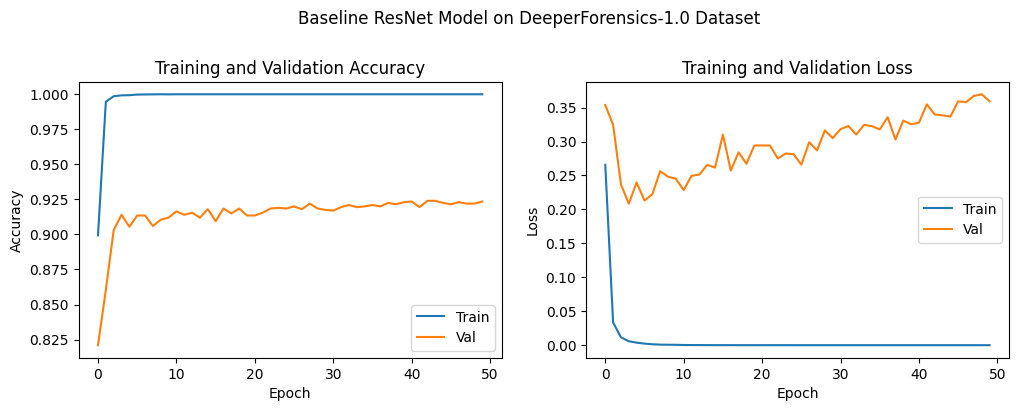

In [21]:
plot_train_result(
    baseline_resnet_df_history.history,
    title="Baseline ResNet Model on DeeperForensics-1.0 Dataset"
)

In [22]:
save_model_and_history(
    baseline_resnet_df_model, baseline_resnet_df_history, "baseline_resnet_df"
)

Model saved at baseline_resnet_df_model.keras
Training history saved at baseline_resnet_df_history.pkl


#### DFDC Dataset

In [23]:
baseline_resnet_dfdc_model = create_resnet_model(best_hp)
baseline_resnet_dfdc_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [24]:
baseline_resnet_dfdc_history = baseline_resnet_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 279ms/step - accuracy: 0.6688 - loss: 0.6158 - val_accuracy: 0.5800 - val_loss: 0.7169
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9266 - loss: 0.2522 - val_accuracy: 0.6235 - val_loss: 0.8175
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9752 - loss: 0.1028 - val_accuracy: 0.6355 - val_loss: 0.9144
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9891 - loss: 0.0531 - val_accuracy: 0.6450 - val_loss: 0.9806
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9940 - loss: 0.0323 - val_accuracy: 0.5975 - val_loss: 1.4502
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9976 - loss: 0.0186 - val_accuracy: 0.6610 - val_loss: 1.0539
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9975 - loss: 0.0134 - val_accuracy: 0.6630 - val_loss: 1.1770
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9992 - loss: 0.0078 

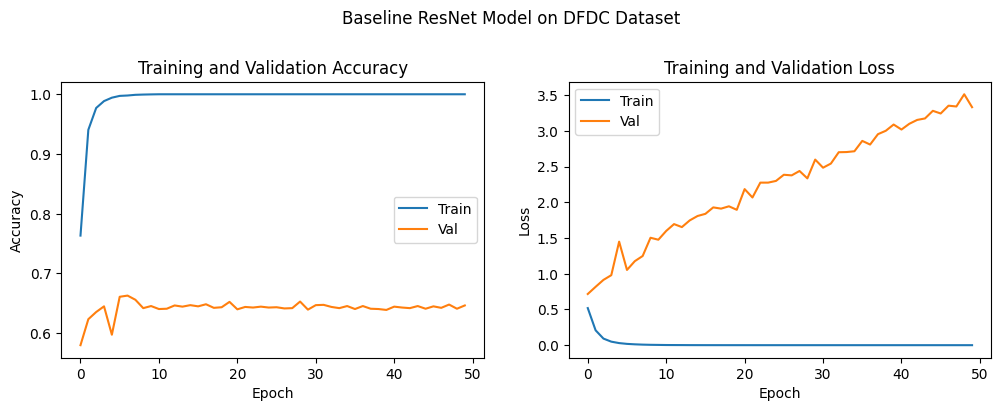

In [25]:
plot_train_result(
    baseline_resnet_dfdc_history.history,
    title="Baseline ResNet Model on DFDC Dataset"
)

In [26]:
save_model_and_history(
    baseline_resnet_dfdc_model, baseline_resnet_dfdc_history, "baseline_resnet_dfdc"
)

Model saved at baseline_resnet_dfdc_model.keras
Training history saved at baseline_resnet_dfdc_history.pkl


### Dropout ResNet Model Training

#### Celeb-DF-v2 Dataset

In [27]:
dropout_resnet_cdf_model = create_resnet_model(best_hp, dropout=True)
dropout_resnet_cdf_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [28]:
dropout_resnet_cdf_history = dropout_resnet_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.5396 - loss: 0.7236 - val_accuracy: 0.6180 - val_loss: 0.6515
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.7268 - loss: 0.5492 - val_accuracy: 0.6510 - val_loss: 0.6427
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.8757 - loss: 0.3118 - val_accuracy: 0.6670 - val_loss: 0.7501
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9398 - loss: 0.1767 - val_accuracy: 0.6800 - val_loss: 0.8604
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9666 - loss: 0.1058 - val_accuracy: 0.6735 - val_loss: 0.9938
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.9801 - loss: 0.0691 - val_accuracy: 0.6745 - val_loss: 1.1249
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9907 - loss: 0.0419 - val_accuracy: 0.7030 - val_loss: 1.1787
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9951 - loss: 0.0262 -

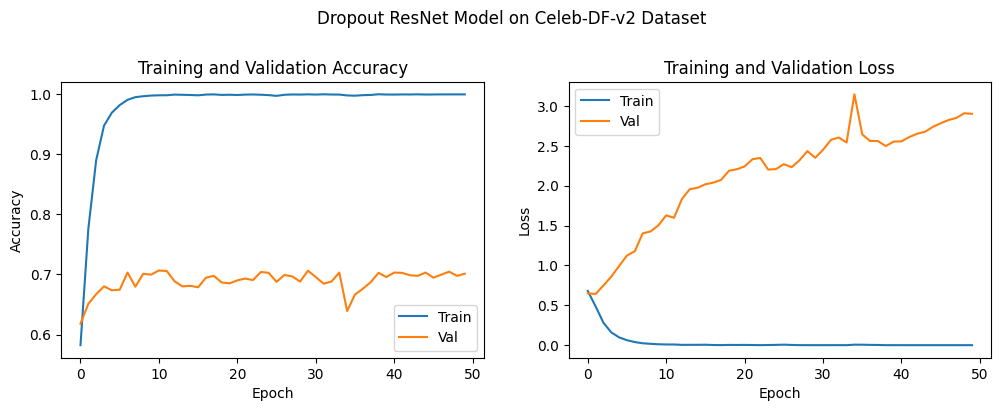

In [29]:
plot_train_result(
    dropout_resnet_cdf_history.history,
    title="Dropout ResNet Model on Celeb-DF-v2 Dataset"
)

In [30]:
save_model_and_history(
    dropout_resnet_cdf_model, dropout_resnet_cdf_history, "dropout_resnet_cdf"
)

Model saved at dropout_resnet_cdf_model.keras
Training history saved at dropout_resnet_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [31]:
dropout_resnet_df_model = create_resnet_model(best_hp, dropout=True)
dropout_resnet_df_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [32]:
dropout_resnet_df_history = dropout_resnet_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 84s 131ms/step - accuracy: 0.6578 - loss: 0.6028 - val_accuracy: 0.7860 - val_loss: 0.4431
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.9587 - loss: 0.1482 - val_accuracy: 0.8305 - val_loss: 0.3622
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9907 - loss: 0.0416 - val_accuracy: 0.8720 - val_loss: 0.2873
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9962 - loss: 0.0204 - val_accuracy: 0.8735 - val_loss: 0.2858
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9973 - loss: 0.0125 - val_accuracy: 0.8800 - val_loss: 0.2790
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.9988 - loss: 0.0068 - val_accuracy: 0.8585 - val_loss: 0.3949
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.9978 - loss: 0.0070 - val_accuracy: 0.8790 - val_loss: 0.3124
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9996 - loss: 0.0035 -

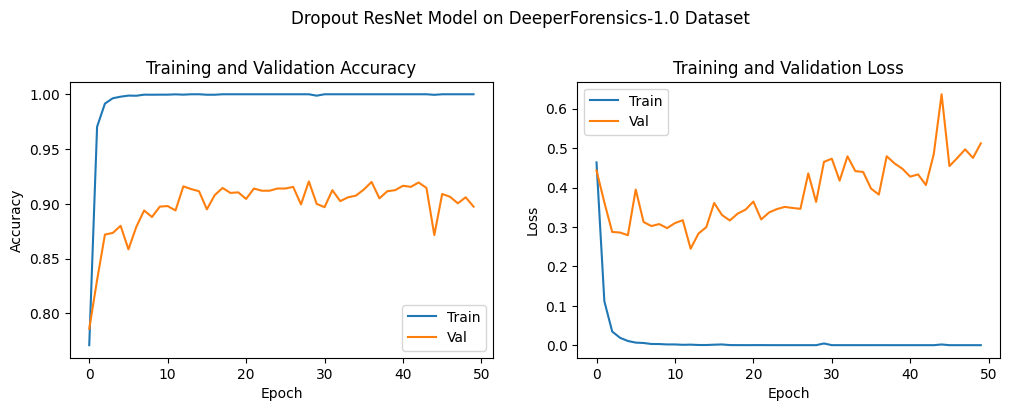

In [33]:
plot_train_result(
    dropout_resnet_df_history.history,
    title="Dropout ResNet Model on DeeperForensics-1.0 Dataset"
)

In [34]:
save_model_and_history(
    dropout_resnet_df_model, dropout_resnet_df_history, "dropout_resnet_df"
)

Model saved at dropout_resnet_df_model.keras
Training history saved at dropout_resnet_df_history.pkl


#### DFDC Dataset

In [35]:
dropout_resnet_dfdc_model = create_resnet_model(best_hp, dropout=True)
dropout_resnet_dfdc_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [36]:
dropout_resnet_dfdc_history = dropout_resnet_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.5470 - loss: 0.7140 - val_accuracy: 0.5460 - val_loss: 0.6804
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.7364 - loss: 0.5371 - val_accuracy: 0.5970 - val_loss: 0.7099
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.8923 - loss: 0.3003 - val_accuracy: 0.6235 - val_loss: 0.8792
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9515 - loss: 0.1530 - val_accuracy: 0.6530 - val_loss: 0.9897
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9761 - loss: 0.0850 - val_accuracy: 0.6345 - val_loss: 1.1715
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9880 - loss: 0.0508 - val_accuracy: 0.6460 - val_loss: 1.1249
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9906 - loss: 0.0356 - val_accuracy: 0.6395 - val_loss: 1.3721
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9957 - loss: 0.0215 -

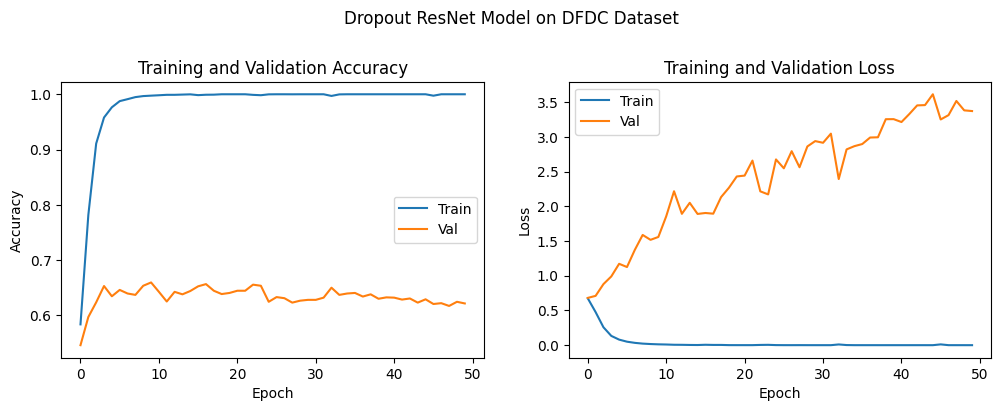

In [37]:
plot_train_result(
    dropout_resnet_dfdc_history.history,
    title="Dropout ResNet Model on DFDC Dataset"
)

In [38]:
save_model_and_history(
    dropout_resnet_dfdc_model, dropout_resnet_dfdc_history, "dropout_resnet_dfdc"
)

Model saved at dropout_resnet_dfdc_model.keras
Training history saved at dropout_resnet_dfdc_history.pkl
